In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
movies_df= pd.read_csv('/content/tmdb_5000_movies.csv')
credits_df= pd.read_csv('/content/tmdb_5000_credits.csv')


In [14]:
credits_df = credits_df.rename(columns={'movie_id': 'id'})
# Merge datasets with explicit suffixes
merged_df = pd.merge(
    movies_df,
    credits_df,
    on='id',
    suffixes=('_movie', '_credits')  # Add distinct suffixes
)
print("Merged shape:", merged_df.shape)
merged_df.head(3)

Merged shape: (3229, 29)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,vote_count,title_y,cast_x,crew_x,title_movie,cast_y,crew_y,title_credits,cast,crew
0,237000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [17]:
# Clean financial data
merged_df['budget'] = merged_df['budget'].replace(0, np.nan)
merged_df['revenue'] = merged_df['revenue'].replace(0, np.nan)
merged_df = merged_df.dropna(subset=['budget', 'revenue'])
def safe_json_parse(x):
    """Safely parse JSON strings that might already be parsed"""
    if isinstance(x, (list, dict)):
        return x
    elif pd.isna(x):
        return []
    try:
        return literal_eval(x)
    except (ValueError, SyntaxError):
        return []
# Convert JSON columns
json_cols = ['genres', 'keywords', 'production_companies', 'production_countries', 'cast', 'crew']
for col in json_cols:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].apply(safe_json_parse)
    else:
        print(f"Column {col} not found in dataframe")

# Verify parsing
print("\nSample parsed data:")
print(merged_df['genres'].head(3))



Sample parsed data:
0    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
Name: genres, dtype: object


In [18]:
# Feature Engineering
def get_director(crew_list):
    for person in crew_list:
        if person['job'] == 'Director':
            return person['name']
    return np.nan

def get_top_actors(cast_list, n=3):
    return [member['name'] for member in sorted(cast_list, key=lambda x: x['order'])[:n]]

merged_df['director'] = merged_df['crew'].apply(get_director)
merged_df['top_actors'] = merged_df['cast'].apply(get_top_actors)
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'])
merged_df['release_year'] = merged_df['release_date'].dt.year
merged_df['release_month'] = merged_df['release_date'].dt.month
merged_df['profit'] = merged_df['revenue'] - merged_df['budget']
merged_df['roi'] = (merged_df['profit'] / merged_df['budget']) * 100

In [19]:
# Revenue Categorization
def categorize_revenue(row):
    if row['revenue'] < row['budget']:
        return 'Flop'
    elif row['revenue'] < 2 * row['budget']:
        return 'Average'
    elif row['revenue'] < 5 * row['budget']:
        return 'Hit'
    else:
        return 'Blockbuster'

merged_df['revenue_category'] = merged_df.apply(categorize_revenue, axis=1)

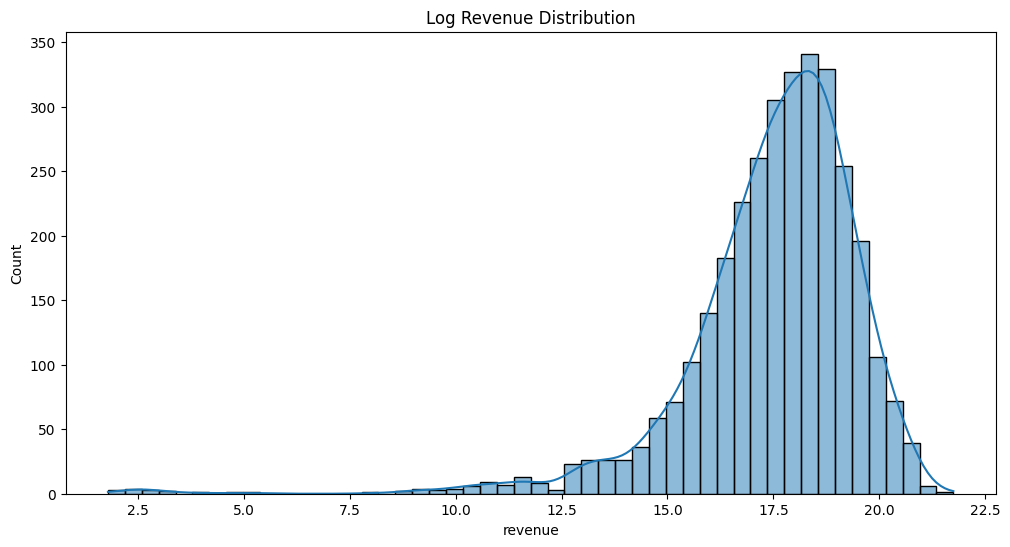

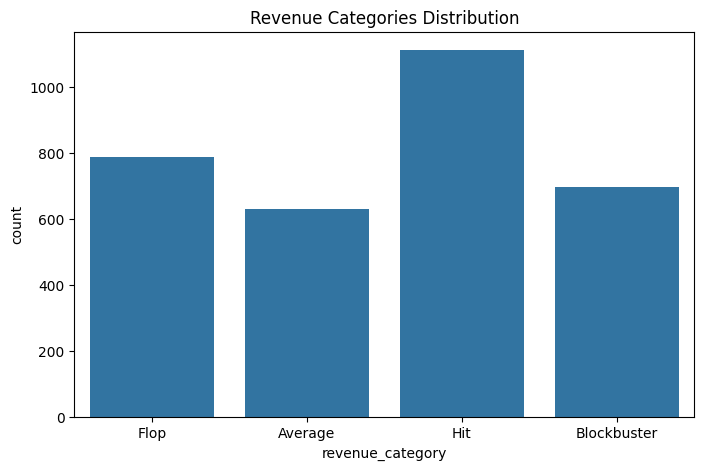

In [20]:
# ## Exploratory Data Analysis

# %%
# Revenue distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(merged_df['revenue']), bins=50, kde=True)
plt.title('Log Revenue Distribution')
plt.show()

# %%
# Revenue categories
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x='revenue_category', order=['Flop', 'Average', 'Hit', 'Blockbuster'])
plt.title('Revenue Categories Distribution')
plt.show()

In [21]:
# Prepare features
features = merged_df[[
    'budget', 'popularity', 'runtime', 'genres',
    'release_year', 'release_month', 'director',
    'top_actors', 'production_companies'
]].copy()

# Convert list columns to strings
features['genres'] = features['genres'].apply(lambda x: ' '.join([g['name'] for g in x]))
features['top_actors'] = features['top_actors'].apply(lambda x: ' '.join(x))
features['production_companies'] = features['production_companies'].apply(lambda x: ' '.join([c['name'] for c in x]))

target = np.log1p(merged_df['revenue'])  # Log transform for better modeling

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

In [30]:

# ## Fixed Preprocessing Pipeline

# %%
# First verify our data
print("X_train shape:", X_train.shape)
print("Text feature lengths:")
print("Genres:", X_train['genres'].apply(len).describe())
print("Actors:", X_train['top_actors'].apply(len).describe())
print("Companies:", X_train['production_companies'].apply(len).describe())

# %%
# Revised Text Preprocessing
class SafeTextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, column, max_features=50):
        self.column = column
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            token_pattern=r'\b\w+\b',  # Match any word character
            min_df=2  # Minimum 2 documents for term to be included
        )
        self.empty_placeholder = None

    def fit(self, X, y=None):
        # Convert to space-separated strings
        text_data = X[self.column].apply(
            lambda x: ' '.join(str(i) for i in x) if isinstance(x, list) else str(x)
        )

        try:
            self.vectorizer.fit(text_data)
            self.empty_placeholder = None
        except ValueError:
            # If empty vocabulary, create placeholder
            self.empty_placeholder = np.zeros((len(X), self.max_features))

        return self
    def transform(self, X):
        text_data = X[self.column].apply(
            lambda x: ' '.join(str(i) for i in x) if isinstance(x, list) else str(x)
        )

        if self.empty_placeholder is not None:
            return self.empty_placeholder[:len(X)]
        try:
            return self.vectorizer.transform(text_data)
        except ValueError:
            return np.zeros((len(X), self.max_features))

# Revised Numeric Preprocessing
numeric_features = ['budget', 'popularity', 'runtime', 'release_year', 'release_month']
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# %%
# Revised Categorical Preprocessing
categorical_features = ['director']
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', max_categories=20))
])

# Revised ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('genres_tfidf', SafeTextPreprocessor('genres'), ['genres']),
    ('actors_tfidf', SafeTextPreprocessor('top_actors'), ['top_actors']),
    ('companies_tfidf', SafeTextPreprocessor('production_companies'), ['production_companies']),
    ('cat', categorical_transformer, categorical_features)
])

required_columns = numeric_features + ['genres', 'top_actors', 'production_companies'] + categorical_features
missing_columns = [col for col in required_columns if col not in X_train.columns]

if missing_columns:
    print(f"Warning: Missing columns {missing_columns}")
    # Create dummy columns if missing
    for col in missing_columns:
        if col in ['genres', 'top_actors', 'production_companies']:
            X_train[col] = X_train.get(col, pd.Series([[]]*len(X_train)))
        else:
            X_train[col] = X_train.get(col, 0)


X_train shape: (2583, 9)
Text feature lengths:
Genres: count    2583.000000
mean       19.775068
std        10.183984
min         0.000000
25%        13.000000
50%        20.000000
75%        26.000000
max        56.000000
Name: genres, dtype: float64
Actors: count    2583.000000
mean       41.081301
std         5.088562
min         0.000000
25%        38.000000
50%        41.000000
75%        44.000000
max        65.000000
Name: top_actors, dtype: float64
Companies: count    2583.000000
mean       62.245451
std        45.369318
min         0.000000
25%        30.000000
50%        53.000000
75%        83.000000
max       472.000000
Name: production_companies, dtype: float64


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - category_accuracy: 0.2409 - category_loss: 1.4166 - loss: 220.7484 - revenue_loss: 219.3213 - revenue_mae: 14.0330 - val_category_accuracy: 0.3514 - val_category_loss: 1.3604 - val_loss: 8.7843 - val_revenue_loss: 7.3870 - val_revenue_mae: 2.0840
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - category_accuracy: 0.3553 - category_loss: 1.3715 - loss: 10.8969 - revenue_loss: 9.5253 - revenue_mae: 2.2252 - val_category_accuracy: 0.3483 - val_category_loss: 1.3545 - val_loss: 8.2322 - val_revenue_loss: 6.8688 - val_revenue_mae: 2.0428
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - category_accuracy: 0.3139 - category_loss: 1.3796 - loss: 8.9898 - revenue_loss: 7.6103 - revenue_mae: 2.0672 - val_category_accuracy: 0.3591 - val_category_loss: 1.3326 - val_loss: 7.2201 - val_revenue_loss: 5.8105 - val_revenue_mae: 1.8654
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - category_accuracy: 0.3377 - category_loss: 1.3505 - loss

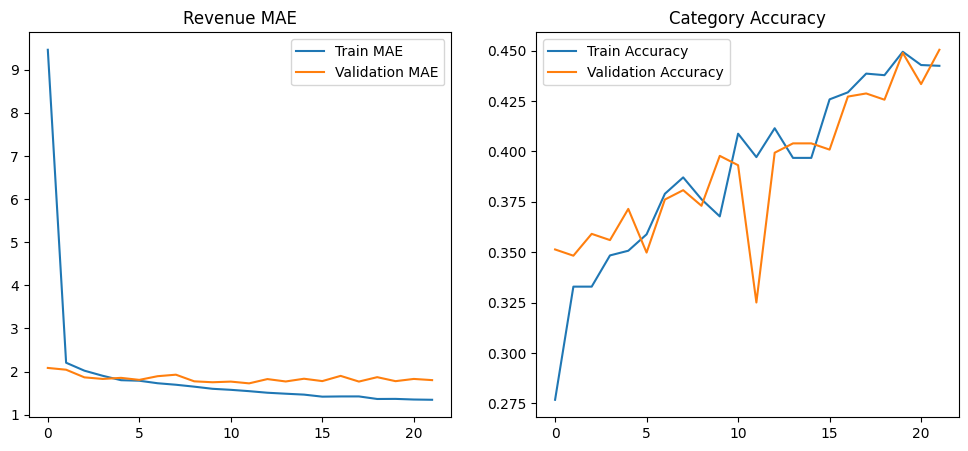

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Sample predictions:
      Actual Revenue  Predicted Revenue Actual Category Predicted Category
449     1.698528e+08        418861248.0             Hit            Average
2098    9.640865e+07         67086788.0     Blockbuster        Blockbuster
299     1.400734e+08         92482080.0         Average            Average
3069    7.000000e+06          8717611.0             Hit        Blockbuster
1590    6.829629e+07          7125367.0             Hit            Average
2090    6.490401e+06            28137.5            Flop               Flop
2631    9.292120e+07         19547812.0     Blockbuster        Blockbuster
93      7.733286e+08         14647058.0             Hit        Blockbuster
1749    1.023914e+08        226760432.0             Hit                Hit
1789    1.935157e+07         76015520.0            Flop            Average

Model Accuracy Results:
Revenue Category Prediction Accuracy: 32.51%

Detailed Classification Report:
            

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# 1. Prepare both regression and classification targets
# Regression target (log revenue)
y_reg = np.log1p(merged_df['revenue'])  # Log transform for better scaling

# Classification target (revenue categories)
y_cat = merged_df['revenue_category']  # Using the category column we created earlier

# Encode categorical labels
le = LabelEncoder()
y_cat_encoded = le.fit_transform(y_cat)

# 2. Split data for both targets
X_train, X_test, y_reg_train, y_reg_test, y_cat_train, y_cat_test = train_test_split(
    features,
    y_reg,
    y_cat_encoded,
    test_size=0.2,
    random_state=42
)

# 3. Preprocessing (using the preprocessor you defined)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert sparse matrix to dense if needed
if hasattr(X_train_preprocessed, "toarray"):
    X_train_preprocessed = X_train_preprocessed.toarray()
    X_test_preprocessed = X_test_preprocessed.toarray()

# 4. Build Neural Network
input_dim = X_train_preprocessed.shape[1]
inputs = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

# Dual outputs
output_reg = Dense(1, name='revenue')(x)  # Regression output
output_cat = Dense(len(le.classes_), activation='softmax', name='category')(x)  # Classification output

model = Model(inputs=inputs, outputs=[output_reg, output_cat])

model.compile(
    optimizer='adam',
    loss={
        'revenue': 'mse',
        'category': 'sparse_categorical_crossentropy'
    },
    metrics={
        'revenue': ['mae'],
        'category': ['accuracy']
    }
)

# 5. Train with Early Stopping
early_stop = EarlyStopping(
    monitor='val_revenue_loss',  # Monitoring revenue loss
    patience=10,
    restore_best_weights=True,
    mode='min'
)

history = model.fit(
    X_train_preprocessed,
    {
        'revenue': y_reg_train,
        'category': y_cat_train
    },
    validation_data=(X_test_preprocessed, {
        'revenue': y_reg_test,
        'category': y_cat_test
    }),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 6. Evaluation and Visualization
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['revenue_mae'], label='Train MAE')
plt.plot(history.history['val_revenue_mae'], label='Validation MAE')
plt.title('Revenue MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['category_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_category_accuracy'], label='Validation Accuracy')
plt.title('Category Accuracy')
plt.legend()
plt.show()

# 7. Make predictions
test_predictions = model.predict(X_test_preprocessed)

# Convert predictions to original scale
revenue_predictions = np.expm1(test_predictions[0].flatten())  # Convert from log scale
category_predictions = le.inverse_transform(np.argmax(test_predictions[1], axis=1))

# Create a DataFrame with results
results_df = pd.DataFrame({
    'Actual Revenue': np.expm1(y_reg_test),
    'Predicted Revenue': revenue_predictions,
    'Actual Category': le.inverse_transform(y_cat_test),
    'Predicted Category': category_predictions
})

print("\nSample predictions:")
print(results_df.head(10))
# Calculate and print accuracy
from sklearn.metrics import accuracy_score

# Get true and predicted categories
y_true_cat = le.inverse_transform(y_cat_test)
y_pred_cat = category_predictions  # Already inverse transformed

# Calculate accuracy
accuracy = accuracy_score(y_true_cat, y_pred_cat)

print("\nModel Accuracy Results:")
print(f"Revenue Category Prediction Accuracy: {accuracy*100:.2f}%")

# Detailed class-wise metrics
from sklearn.metrics import classification_report
print("\nDetailed Classification Report:")
print(classification_report(y_true_cat, y_pred_cat))